__title__      = ML in Action Chapter8 Code（预测鲍鱼年龄）
__author__     = wgj
__createDate__ = 2018-11-03 21:20:19

In [31]:
from numpy import *
import matplotlib.pyplot as plt

""" 加载数据集 """
def loadDataSet(fileName): 
    numFeat = len(open(fileName).readline().split('\t')) - 1 #  数据集列数（末列为真值）
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]                                                 # 保存一行训练数据
        curLine = line.strip().split('\t')                # 移除每行首尾空格并用tab分割数据
        for i in range(numFeat):                        # 遍历所有列
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

""" 标准线性回归 """
def standRegres(xArr,yArr):
    """ 
    输入：1、xArr——输入变量
                2、yArr——目标值
    输出：ws——回归系数
    """
    xMat = mat(xArr); yMat = mat(yArr).T
    xTx = xMat.T*xMat
    if linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T*yMat)
    return ws

""" 局部加权线性回归 """
def lwlr(testPoint,xArr,yArr,k=1.0):
    """ 
    输入：1、testPoint——测试点
                2、xArr——输入变量
                3、yArr——目标值
                4、k——权值
    输出：testPoint * ws——预测结果
    """
    xMat = mat(xArr); yMat = mat(yArr).T
    m = shape(xMat)[0]
    weights = mat(eye((m)))                  # 创建对角矩阵
    for j in range(m):                             # 计算高斯核对应的权重
        diffMat = testPoint - xMat[j,:] 
        weights[j,j] = exp(diffMat*diffMat.T/(-2.0*k**2))
    xTx = xMat.T * (weights * xMat)
    if linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T * (weights * yMat))
    return testPoint * ws

""" 逐点调用lwlr() """
def lwlrTest(testArr,xArr,yArr,k=1.0): 
    """ 
    输入：1、testArr——测试点集合
                2、xArr——输入变量
                3、yArr——目标值
                4、k——权值
    输出：yHat——预测结果
    """
    m = shape(testArr)[0]
    yHat = zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i],xArr,yArr,k)
    return yHat

""" 计算回归误差（平方和）"""
def rssError(yArr,yHatArr): 
    """ 
    输入：1、yArr——目标值
                2、yHatArr——预测结果
                （计算元素平方，输入需均为arrays类型）
    输出：回归误差
    """
    return ((yArr-yHatArr)**2).sum()

测试局部加权线性回归

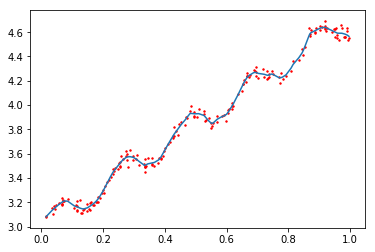

In [5]:
xArr, yArr = loadDataSet('ex0.txt')
yHat = lwlrTest(xArr, xArr, yArr,0.01)
xMat = mat(xArr)
srtInd = xMat[:,1].argsort(0)   # 对输入变量按照第2列升序排列
xSort = xMat[srtInd][:,0,:]

""" 绘制图形 """
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xSort[:,1], yHat[srtInd])   # 拟合曲线
ax.scatter(xMat[:,1].flatten().A[0], mat(yArr).T.flatten().A[0], s=2, c='red')   # 原始数据点
plt.show()

岭回归算法

In [2]:
""" 岭回归算法 """
def ridgeRegres(xMat,yMat,lam=0.2):
    """ 
    输入：1、xMat——输入变量
                2、yMat——目标值
                3、lam——系数
    输出：ws——回归系数
    """
    xTx = xMat.T*xMat
    denom = xTx + eye(shape(xMat)[1])*lam
    if linalg.det(denom) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = denom.I * (xMat.T*yMat)
    return ws

""" 在1组lam上进行岭回归测试 """
def ridgeTest(xArr,yArr):
    """ 
    输入：1、xArr——输入变量
                2、yArr——目标值
    输出：wMat——回归系数
    """
    xMat = mat(xArr); yMat=mat(yArr).T
    yMean = mean(yMat,0)
    yMat = yMat - yMean     #to eliminate X0 take mean off of Y
    # 正则化X（减均值，再除以方差）
    xMeans = mean(xMat,0)   # 按列计算均值
    xVar = var(xMat,0)              # 按列计算方差
    xMat = (xMat - xMeans)/xVar
    numTestPts = 30                # 测试次数
    wMat = zeros((numTestPts,shape(xMat)[1]))    # 回归系数矩阵（1行代表1组系数）
    for i in range(numTestPts):     # 每次变更lambda
        ws = ridgeRegres(xMat,yMat,exp(i-10))
        wMat[i,:]=ws.T
    return wMat

在鲍鱼数据集上测试岭回归算法

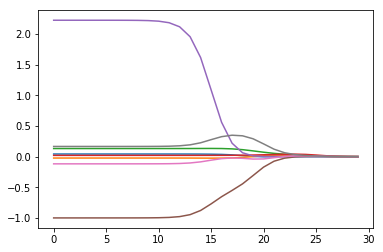

In [13]:
xArr, yArr = loadDataSet('abalone.txt')
ridgeWeights = ridgeTest(xArr, yArr)       # 岭回归算法计算出的系数

""" 绘制图形 """
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ridgeWeights)   # 回归系数曲线
plt.show()


前向逐步线性回归

In [28]:
""" 按列正则化 """
def regularize(xMat):
    """ 
    输入：xMat——输入变量
    输出：inMat——正则化结果
    """
    inMat = xMat.copy()
    inMeans = mean(inMat,0)   # 按列计算均值
    inVar = var(inMat,0)             # 按列计算方差
    inMat = (inMat - inMeans)/inVar
    return inMat

""" 前向逐步线性回归 """
def stageWise(xArr,yArr,eps=0.01,numIt=100):
    """ 
    输入：1、xArr——输入变量
                2、yArr——目标值
                3、eps——系数变化量（步长）
                4、numIt——迭代次数
    输出：ws——回归系数
    """
    xMat = mat(xArr); yMat=mat(yArr).T
    yMean = mean(yMat,0)
    yMat = yMat - yMean
    xMat = regularize(xMat)      # 正则化输入变量（满足0均值和单位方差）
    m,n=shape(xMat)
    ws = zeros((n,1)); wsTest = ws.copy(); wsMax = ws.copy()   # 初始化所有系数为1
    for i in range(numIt):
#         print(ws.T)
        lowestError = inf;         # 每轮迭代设置当前最小误差为正无穷
        for j in range(n):          # 遍历每个特征
            for sign in [-1,1]:     # 系数变化方式（增或减）
                wsTest = ws.copy()
                wsTest[j] += eps*sign                   # 微调系数
                yTest = xMat*wsTest
                rssE = rssError(yMat.A,yTest.A)   # 计算新的误差（×.A从mat转为array）
                if rssE < lowestError:                    # 在新误差<当前最小误差时，保存系数
                    lowestError = rssE
                    wsMax = wsTest                        
        ws = wsMax.copy()
    return ws

在鲍鱼数据集上测试前向逐步线性回归算法

In [32]:
stageWeights = stageWise(xArr, yArr, 0.001, 5000)   # 前向逐步线性回归算法计算出的系数
xMat = mat(xArr); yMat=mat(yArr).T
xMat = regularize(xMat) 
yM = mean(yMat,0)
yMat = yMat - yM
ws = standRegres(xMat,yMat.T)                                    # 标准线性回归算法计算出的系数
print('前向逐步线性回归计算系数为：', stageWeights.T)
print('标准线性回归计算系数为：', ws.T)

前向逐步线性回归计算系数为： [[ 0.043 -0.011  0.12   0.022  2.023 -0.963 -0.105  0.187]]
标准线性回归计算系数为： [[ 0.0430442  -0.02274163  0.13214087  0.02075182  2.22403814 -0.99895312
  -0.11725427  0.16622915]]
